# Cluster Orientation Analysis

## Import Data

In [2]:
import matplotlib.pyplot as plt
import cmcrameri
import h5py
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from scipy import ndimage
import seaborn as sns
import pandas as pd
from cmcrameri import cm

import sys
sys.path.append('./..')

from src.utils import get_cluster_labels, get_ds_iters
from src.waffle_plot import waffle_plot

#from src.plot_utils import get_plot_configs

#plot_configs = get_plot_configs()
#plt.rcParams.update(plot_configs)

## Define Functions

In [3]:
def plot_labelled_cluster(axis, file, sshot_idx):
    cmap_label = plt.get_cmap(name="gnuplot")
    #cmap_label = 'cmc.acton'
    labelled, _ = get_cluster_labels(file, sshot_idx)
    axis.matshow(labelled, cmap=cmap_label)
    return axis


def get_biggest_cluster(img):
    kernel = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
    labelled, _ = ndimage.label(img, structure=kernel)
    lb = labelled.flatten()
    cluster_sizes = np.bincount(lb)[1:]
    biggest_cluster_id = np.argmax(cluster_sizes)
    loc = ndimage.find_objects(labelled)[biggest_cluster_id]
    labelled_crop = labelled[loc]
    img_crop = img[loc]
    labelled_crop[labelled_crop != biggest_cluster_id+1] = 0
    labelled_crop[labelled_crop == biggest_cluster_id+1] = 1
    img_crop *= labelled_crop
    return img_crop, ndimage.center_of_mass(labelled_crop)

def get_edges(img,axis):
    img_threshold = np.zeros_like(img)
    img_threshold[img > 0] = 1
    edges = ndimage.sobel(img_threshold, axis=axis)
    #edges[edges > -2] = 0
    #edges[edges != 0] = 1
    edges *= img
    return edges

def map_ori(ori):
    ori_mapped = np.zeros_like(ori, dtype=np.float_)
    ori_mapped[ori == 1] = np.pi
    ori_mapped[ori == 2] = np.pi/2
    ori_mapped[ori == 3] = 0
    ori_mapped[ori == 4] = -np.pi/2
    return ori_mapped


def map_ori_human(ori):
    ori_mapped = np.zeros_like(ori, dtype=np.dtype('U100'))
    ori_mapped[ori == 3] = "Down"
    ori_mapped[ori == 2] = "Right"
    ori_mapped[ori == 1] = "Up"
    ori_mapped[ori == 4] = "Left"
    return ori_mapped


# 0: y, 1: x
def get_ori_and_loc(edges,com):
    positions = edges.nonzero()
    edges_ori = map_ori(edges[positions[0],positions[1]])
    edges_loc = np.arctan2((com[0]-positions[0]),(positions[1]-com[1]))

    # CHECK CODE
    # colors = ListedColormap(["k", "r", "yellow", "g", "b"])
    # edges[edges == 0] = -4
    # edges[positions[0],positions[1]] = edges_loc
    plt.matshow(edges)
    plt.colorbar()
    plt.axvline(com[1], c='w')
    plt.axhline(com[0], c='w')

    return edges_ori, edges_loc

## Plot Cluster Map

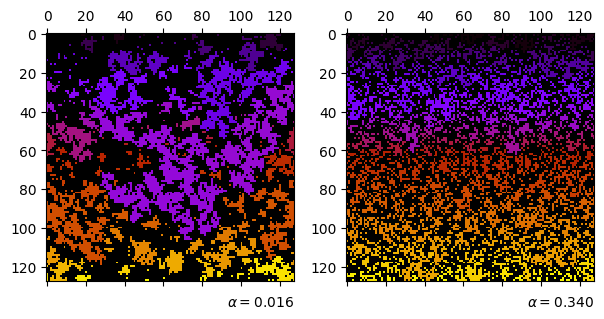

In [4]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
sshot_idx = -1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
ax1 = plot_labelled_cluster(ax1, "../data/no-rolling/dataset_tumble_0.016_density_0.4.h5", sshot_idx)
ax1.text(
    y=-0.1,
    x=1,
    transform=ax1.transAxes,
    ha="right",
    s=r"$\alpha = 0.016$",
)
ax2 = plot_labelled_cluster(ax2, "../data/no-rolling/dataset_tumble_0.340_density_0.4.h5", sshot_idx)
ax2.text(
    y=-0.1,
    x=1,
    transform=ax2.transAxes,
    ha="right",
    s=r"$\alpha = 0.340$",
)
plt.show()
fig.savefig("../plots/cluster_orientation_analysis/cluster_map.svg")

## Get Frequency of Up-Down Edge Orientations

In [5]:
hf = h5py.File(f"../data/no-rolling/dataset_tumble_0.016_density_0.4.h5", "r")
iters = get_ds_iters(hf.keys())
img = hf[f"conf_{iters[300]}"]
img = np.array(img)

img2 = get_edges(img, axis=0)
img2[img2<0] = -1
img2[img2>0] = 1

locs_neg = np.where(img2 == -1)
locs_mid = np.where(img2 == 0)
locs_pos = np.where(img2 == 1)

neg = img[locs_neg[0][:],locs_neg[1][:]]
mid = img[locs_mid[0][:],locs_mid[1][:]]
pos = img[locs_pos[0][:],locs_pos[1][:]]

counts = np.column_stack((np.bincount(neg),np.bincount(pos)))[1:]

df = pd.DataFrame({
    'Grad': (["Negative"]+["Positive"])*4,
    'Orientation': pd.Categorical(
        ["Up", "Up", "Right", "Right", "Down", "Down", "Left", "Left"],
        categories=["Left", "Up", "Right", "Down"]
    ),
    'Frequency': counts.flatten(),
        })
df.to_csv("cache/updown_ori_freq.csv")

## Get Frequency of Left-Right Edge Orientations

In [6]:
hf = h5py.File(f"../data/no-rolling/dataset_tumble_0.016_density_0.4.h5", "r")
iters = get_ds_iters(hf.keys())
img = hf[f"conf_{iters[300]}"]
img = np.array(img)

img2 = get_edges(img, axis=1)
img2[img2<0] = -1
img2[img2>0] = 1

locs_neg = np.where(img2 == -1)
locs_mid = np.where(img2 == 0)
locs_pos = np.where(img2 == 1)

neg = img[locs_neg[0][:],locs_neg[1][:]]
mid = img[locs_mid[0][:],locs_mid[1][:]]
pos = img[locs_pos[0][:],locs_pos[1][:]]

counts = np.column_stack((np.bincount(neg),np.bincount(pos)))[1:]

df = pd.DataFrame({
    'Grad': (["Negative"]+["Positive"])*4,
   'Orientation': pd.Categorical(
       ["Up", "Up", "Right", "Right", "Down", "Down", "Left", "Left"],
       categories=["Left", "Up", "Right", "Down"]
   ),
    'Frequency': counts.flatten(),
        })
df.to_csv("cache/leftright_ori_freq.csv")

## Get Frequency of Up-Down Scrambled Edge Orientations

In [7]:
hf = h5py.File(f"../data/no-rolling/dataset_tumble_0.016_density_0.4.h5", "r")
iters = get_ds_iters(hf.keys())
img = hf[f"conf_{iters[300]}"]
img = np.array(img)
img[img > 0] = 1
img = img * np.random.randint(1, 5, size=(128, 128))

img2 = get_edges(img, axis=0)
img2[img2<0] = -1
img2[img2>0] = 1

locs_neg = np.where(img2 == -1)
locs_mid = np.where(img2 == 0)
locs_pos = np.where(img2 == 1)

neg = img[locs_neg[0][:],locs_neg[1][:]]
mid = img[locs_mid[0][:],locs_mid[1][:]]
pos = img[locs_pos[0][:],locs_pos[1][:]]

counts = np.column_stack((np.bincount(neg),np.bincount(pos)))[1:]

df = pd.DataFrame({
    'Grad': (["Negative"]+["Positive"])*4,
    'Orientation': pd.Categorical(
        ["Up", "Up", "Right", "Right", "Down", "Down", "Left", "Left"],
        categories=["Left", "Up", "Right", "Down"]
    ),
    'Frequency': counts.flatten(),
        })
df.to_csv("cache/updown_ori_freq_scrambled.csv")

## Get Frequency of Left-Right Scrambled Edge Orientations

In [8]:
hf = h5py.File(f"../data/no-rolling/dataset_tumble_0.016_density_0.4.h5", "r")
iters = get_ds_iters(hf.keys())
img = hf[f"conf_{iters[300]}"]
img = np.array(img)
img[img > 0] = 1
img = img * np.random.randint(1, 5, size=(128, 128))

img2 = get_edges(img, axis=1)
img2[img2<0] = -1
img2[img2>0] = 1

locs_neg = np.where(img2 == -1)
locs_mid = np.where(img2 == 0)
locs_pos = np.where(img2 == 1)

neg = img[locs_neg[0][:],locs_neg[1][:]]
mid = img[locs_mid[0][:],locs_mid[1][:]]
pos = img[locs_pos[0][:],locs_pos[1][:]]

counts = np.column_stack((np.bincount(neg),np.bincount(pos)))[1:]

df = pd.DataFrame({
    'Grad': (["Negative"]+["Positive"])*4,
    'Orientation': pd.Categorical(
        ["Up", "Up", "Right", "Right", "Down", "Down", "Left", "Left"],
        categories=["Left", "Up", "Right", "Down"])
    ,
    'Frequency': counts.flatten(),
        })
df.to_csv("cache/leftright_ori_freq_scrambled.csv")

## Plot Cluster Edge Orientations

/tmp/ipykernel_13085/2311038860.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["↑","↓","→","←"])
/tmp/ipykernel_13085/2311038860.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["↑","↓","→","←"])


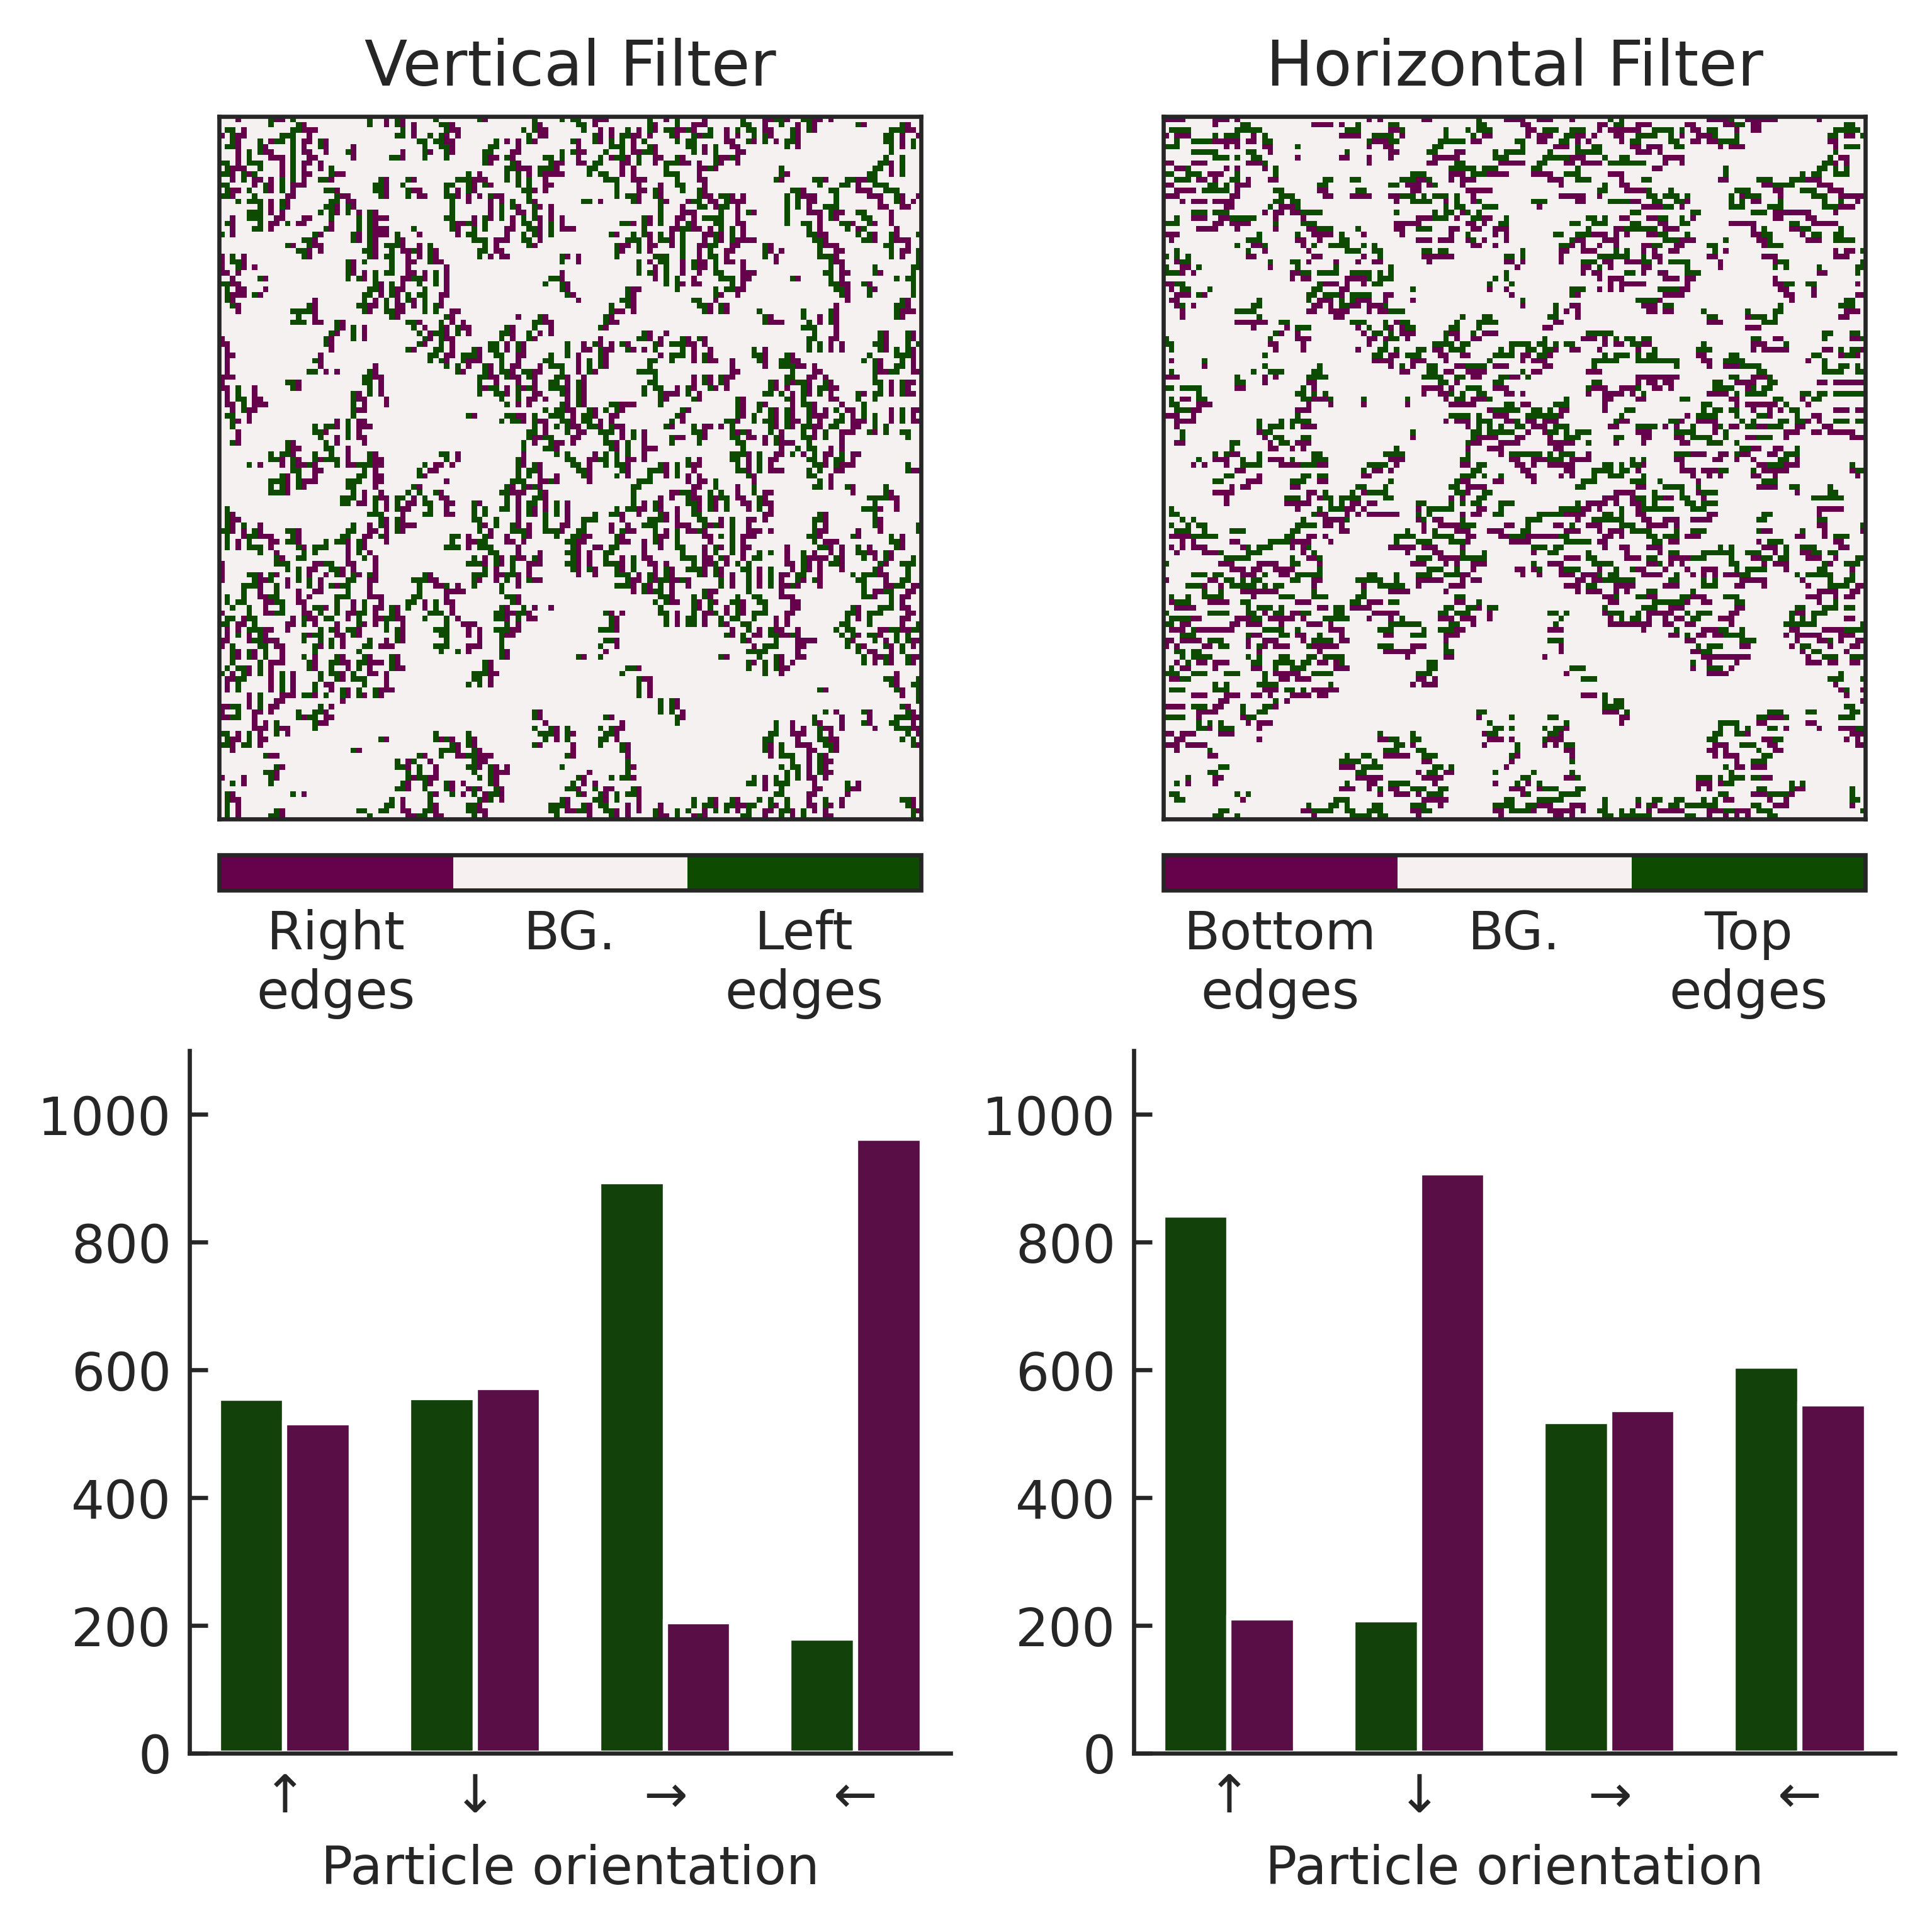

In [14]:
#mpl.rcParams.update(mpl.rcParamsDefault)

df = pd.read_csv("cache/leftright_ori_freq_scrambled.csv")

#plot_configs = get_plot_configs()
#sns.set(rc=plot_configs)
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
#plt.rcParams.update(plot_configs)
fig = plt.figure(figsize=(5,5), constrained_layout=True,dpi=600)
#ax0 = fig.add_subplot(
#    1, 1, 1
#)
ax4 = fig.add_subplot(
    2, 2, 1
)
ax2 = fig.add_subplot(
    2, 2, 2
)
ax3 = fig.add_subplot(
    2, 2, 3
)
ax1 = fig.add_subplot(
    2, 2, 4
)

hf = h5py.File(f"../data/no-rolling/dataset_tumble_0.016_density_0.4.h5", "r")
iters = get_ds_iters(hf.keys())
img = hf[f"conf_{iters[300]}"]
img = np.array(img)
img_thres = img
img_thres[img_thres>0]=1
#axins = inset_axes(ax4, width="100%", height="100%", borderpad=1)
#axins.set_axes_locator(InsetPosition(ax4, [.7, 1.3, 1, 1]))
#axins.matshow(img_thres, cmap='cmc.oslo')
#axins.tick_params(
#    axis = "both",
#    which = "both",
#    length = 0,
#    labelleft = False,
#    labeltop = False,
#)
img2 = get_edges(img, axis=0)
img2[img2<0] = -1
img2[img2>0] = 1
cbar = ax2.matshow(img2, cmap=plt.get_cmap(cm.bam, lut=3))
cb = plt.colorbar(cbar, ax=ax2, ticks=np.arange(-1, 1 + 1), values=np.arange(-1, 1 + 1), location='bottom', fraction=0.05)
cb.set_ticklabels(["Bottom\nedges", "BG.", "Top\nedges"])
ax2.tick_params(
    axis = "both",
    which = "both",
    length = 0,
    labelleft = False,
    labeltop = False,
)

img2 = get_edges(img, axis=1)
img2[img2<0] = -1
img2[img2>0] = 1
cbar = ax4.matshow(img2, cmap=plt.get_cmap(cm.bam, lut=3))
cb = plt.colorbar(cbar, ax=ax4, ticks=np.arange(-1, 1 + 1), values=np.arange(-1, 1 + 1), location='bottom', fraction=0.05)
cb.set_ticklabels(["Right\nedges", "BG.", "Left\nedges"])
ax4.tick_params(
    axis = "both",
    which = "both",
    length = 0,
    labelleft = False,
    labeltop = False,
)

palette = {'Negative': '#0C4B00', 'Positive': '#65024B' }
df = pd.read_csv("cache/updown_ori_freq.csv")
sns.barplot(ax=ax1, data=df, x='Orientation',y='Frequency', hue='Grad', palette=palette, legend=False, width=0.7, order=["Up","Down","Left","Right"])
ax1.set(xticklabels=[])

#df = pd.read_csv("cache/updown_ori_freq_scrambled.csv")
#sns.barplot(ax=ax2, data=df, x='Orientation',y='Frequency', hue='Grad', palette=palette)
#ax2.set(xlabel=None, xticklabels=[], ylabel=None, yticklabels=[])
#sns.move_legend(ax2, "upper right", bbox_to_anchor=(1, 1.1), frameon=False, title=r"Gradient")

df = pd.read_csv("cache/leftright_ori_freq.csv")
sns.barplot(ax=ax3, data=df, x='Orientation',y='Frequency', hue='Grad', palette=palette, legend=False, width=0.7, order=["Up","Down","Left","Right"])

#df = pd.read_csv("cache/leftright_ori_freq_scrambled.csv")
#sns.barplot(ax=ax5, data=df, x='Orientation',y='Frequency', hue='Grad', palette=palette, legend=False)
#ax5.set(yticklabels=[])


for idx, ax in enumerate((ax1,ax3)):
    sns.despine(ax=ax)
    ax.set_ylim(0,1100)
    ax.set(xlabel=None, ylabel=None)
    ax.set_xticklabels(["↑","↓","→","←"])
    #ax.set_ylabel('Particle count', fontsize=14)
    ax.set_xlabel("Particle orientation")

ax4.set_title("Vertical Filter")
ax2.set_title("Horizontal Filter")

#fig.text(s="(A)",x=0.17, y=0.95)
#fig.text(s="(B)",x=0.52, y=0.95, backgroundcolor=(1,1,1,0.95))
#fig.text(s="(C)",x=0.17, y=0.48)
#fig.text(s="(D)",x=0.52, y=0.48, backgroundcolor=(1,1,1,0.95))
fig.savefig("../plots/cluster_orientation_analysis/cluster_edge_orientations.png", bbox_inches='tight')

## Plot Waffle Plot Distribution For Horizontal Filter

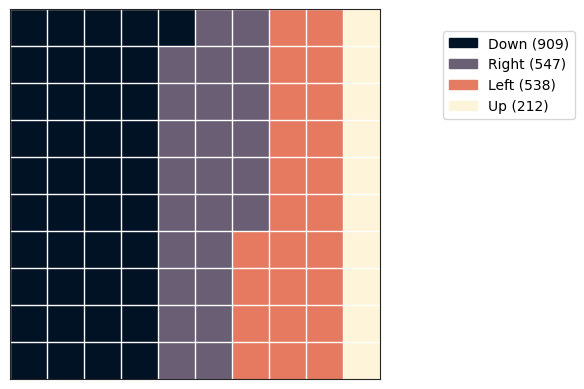

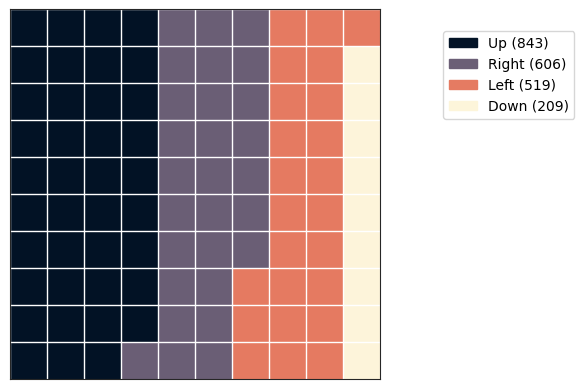

In [10]:
df = pd.read_csv("cache/updown_ori_freq.csv")
sns.barplot(ax=ax1, data=df, x='Orientation',y='Frequency', hue='Grad', palette=palette, legend=False)
ax1.set(xticklabels=[])

waffle_plot(df[df['Grad'] == "Positive"]['Orientation'], df[df['Grad'] == "Positive"]['Frequency'], cmap=cm.lipari)
waffle_plot(df[df['Grad'] == "Negative"]['Orientation'], df[df['Grad'] == "Negative"]['Frequency'], cmap=cm.lipari)

## Frequency Comparison

In [11]:
df = pd.read_csv("cache/updown_ori_freq.csv")
df2 = pd.read_csv("cache/updown_ori_freq_scrambled.csv")

df3 = pd.read_csv("cache/leftright_ori_freq.csv")
df4 = pd.read_csv("cache/leftright_ori_freq_scrambled.csv")

diff1 = (df[df['Grad'] == "Positive"]['Frequency'].values - df[df['Grad'] == "Negative"]['Frequency'].values)
diff1[[1,2]] = diff1[[2,1]]

diff2 = (df3[df3['Grad'] == "Positive"]['Frequency'].values - df3[df3['Grad'] == "Negative"]['Frequency'].values)
diff2[[1,2]] = diff2[[2,1]]

diff3 = (df2[df2['Grad'] == "Positive"]['Frequency'].values - df2[df2['Grad'] == "Negative"]['Frequency'].values)
diff3[[1,2]] = diff3[[2,1]]

diff4 = (df4[df4['Grad'] == "Positive"]['Frequency'].values - df4[df4['Grad'] == "Negative"]['Frequency'].values)
diff4[[1,2]] = diff4[[2,1]]

ori = np.array(["Up", "Left", "Down", "Right"])
ori[[1,2]] = ori[[2,1]]

len(np.tile(ori,2))

diff_v = pd.DataFrame({
    "Difference": np.concatenate((
        diff1,
        diff2
    )),
    "Orientation": np.tile(ori,2),
    'Context': (["Vertical filter"]*4+["Horizontal filter"]*4)*1,
})


diff_v2 = pd.DataFrame({
    "Difference": np.concatenate((
        diff3,
        diff4,
    )),
    "Orientation": np.tile(ori,2),
    'Context': (["Vertical filter"]*4+["Horizontal filter"]*4)*1,
})


[Text(0, 0.5, 'Difference between opposing edges')]

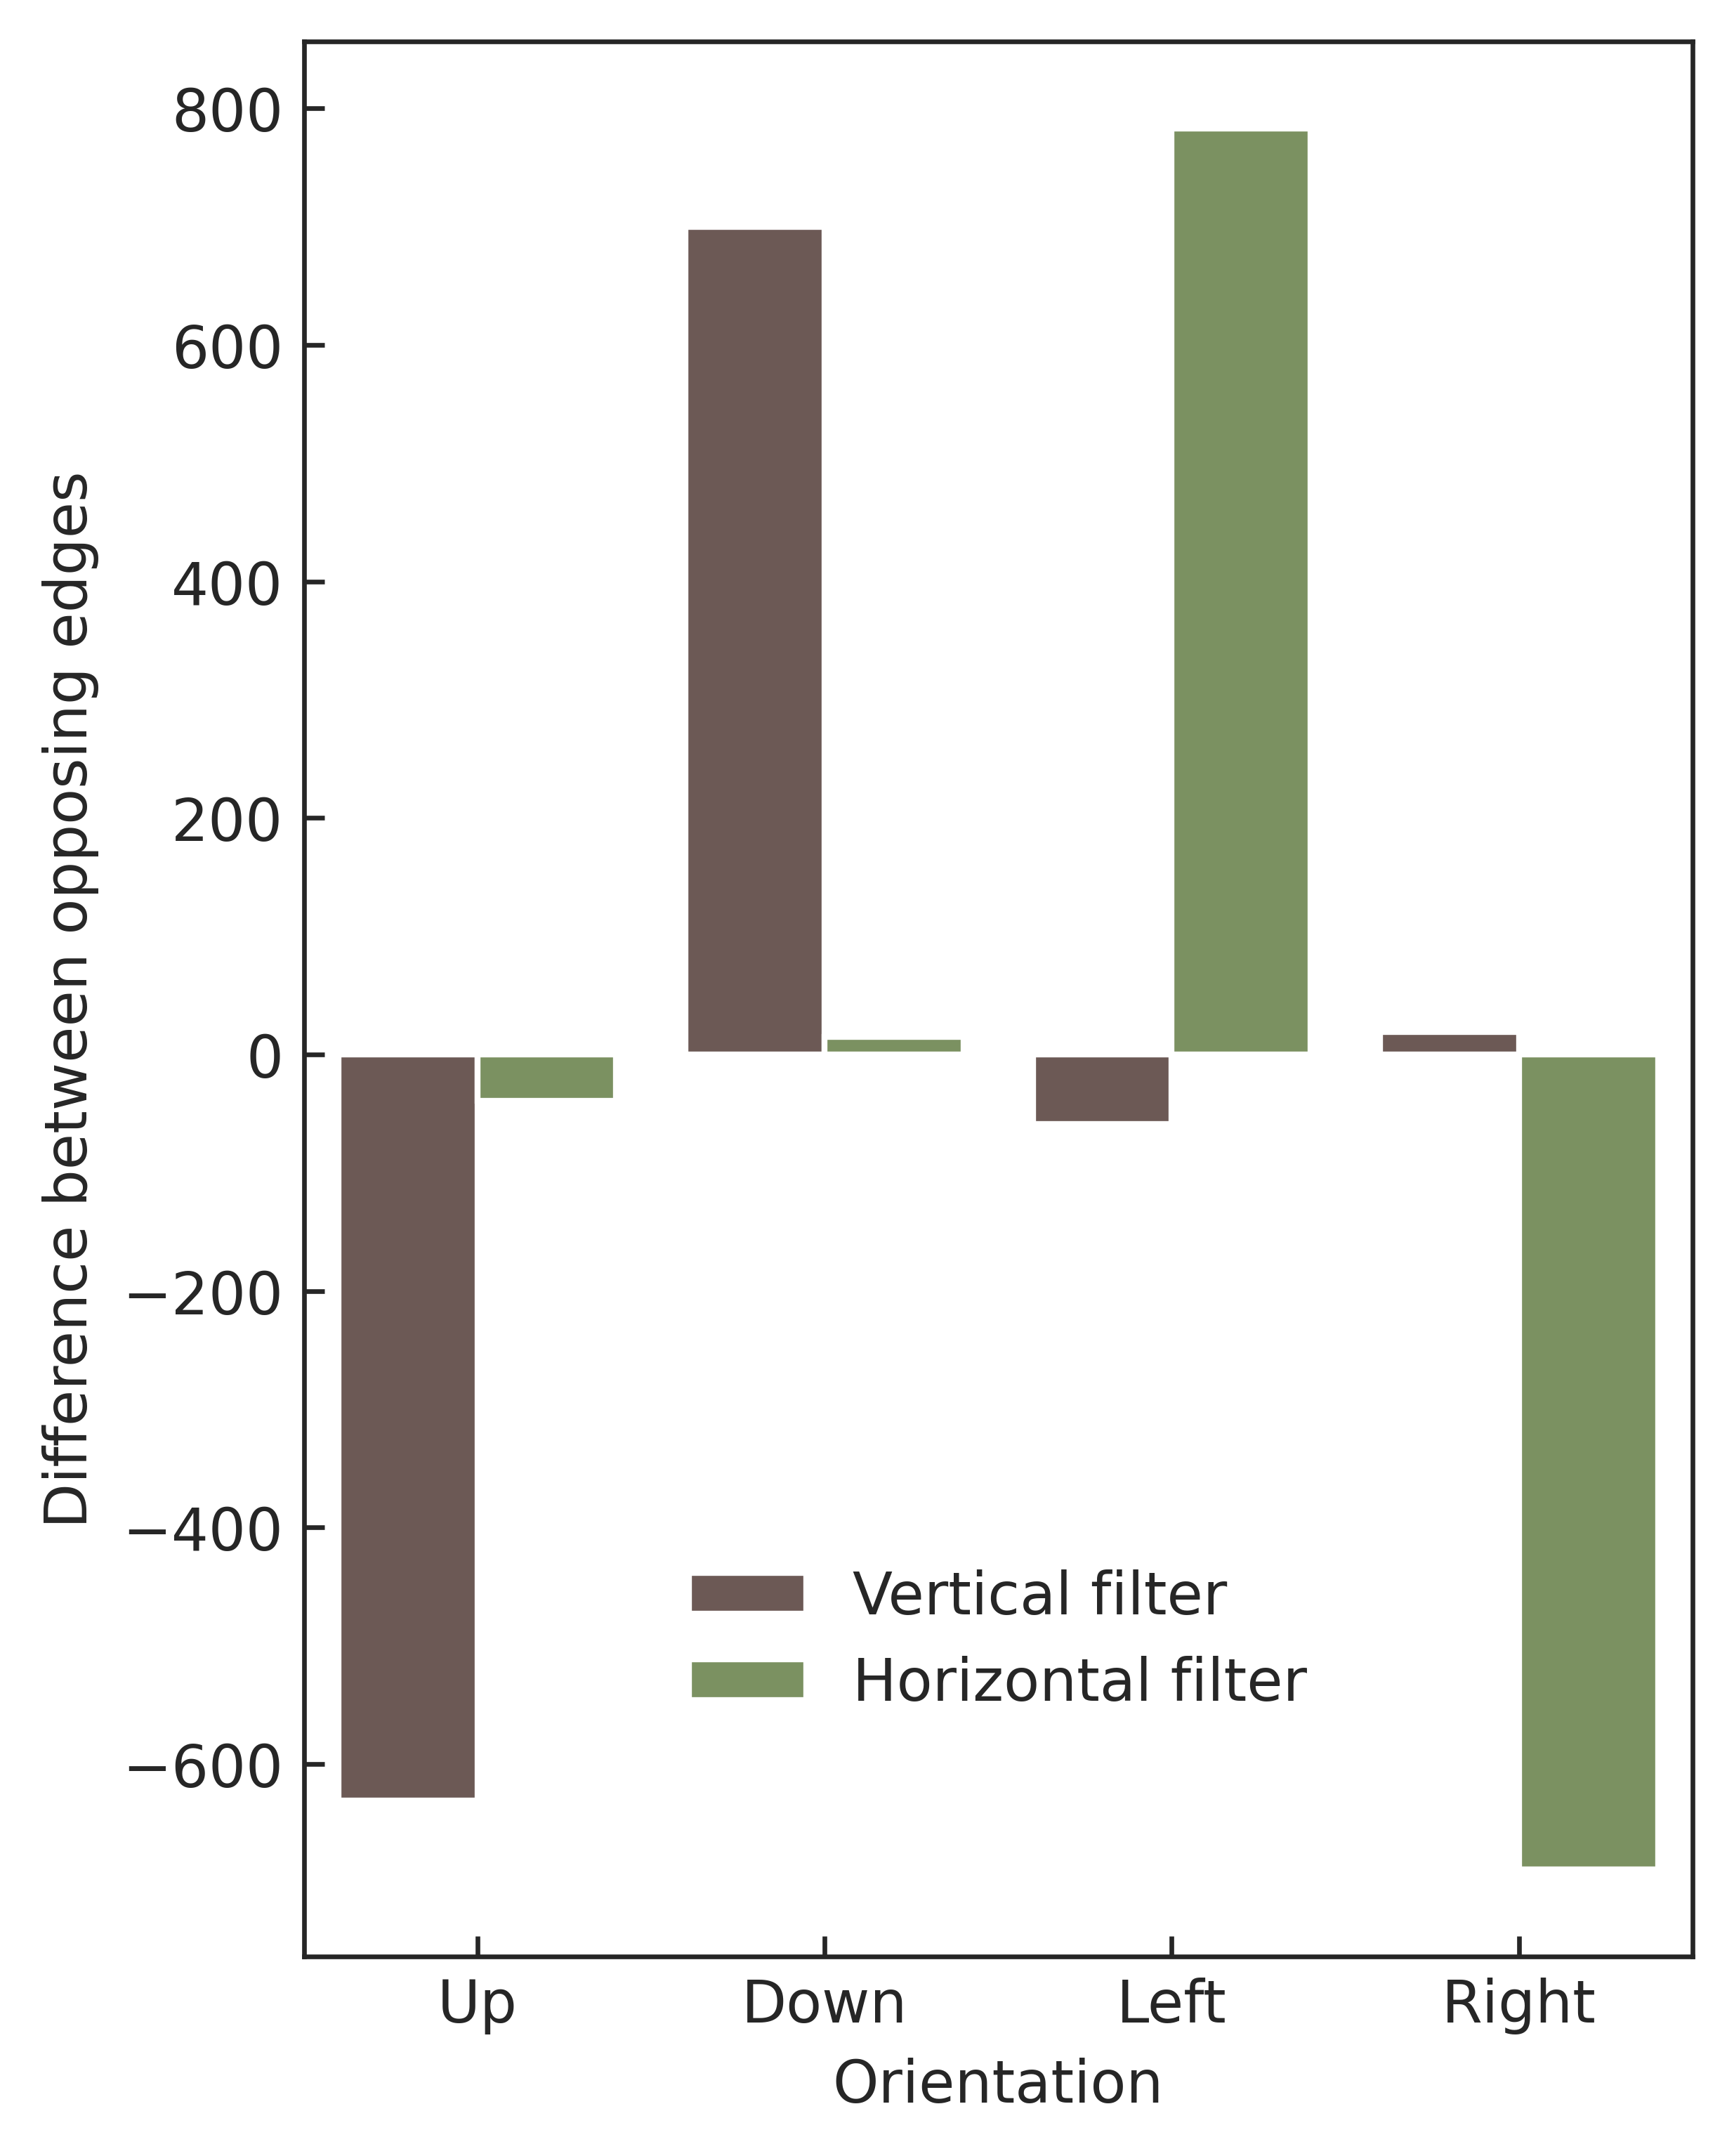

In [15]:
fig = plt.figure(figsize=(4,5), constrained_layout=True,dpi=600)

ax1 = sns.barplot(data=diff_v, x='Orientation',y='Difference', palette='cmc.tokyo', hue='Context')

sns.move_legend(ax1, "lower center", bbox_to_anchor=(0.5, 0.1), frameon=False, title=None)

ax1.set(ylabel="Difference between opposing edges")